# Fine-tuning an Image Caption model

In [4]:
# Check GPU is detected by CUDA
import torch
print(torch.cuda.is_available())


True


In [5]:
# Check if CPU is supported by IPEX
#import intel_extension_for_pytorch as ipex
#
#print(ipex.cpu.runtime.is_runtime_ext_enabled())


## Download pretrained model

In [1]:
from transformers import BlipProcessor, BlipForConditionalGeneration

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
checkpoint = "Salesforce/blip-image-captioning-base"

processor = BlipProcessor.from_pretrained(checkpoint)
model = BlipForConditionalGeneration.from_pretrained(checkpoint).to(device)

print(model.get_memory_footprint())


/home/christian/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


989660400


## Load data

In [7]:
import pandas as pd

df_train = pd.read_csv('ids_train.csv')
df_test = pd.read_csv('ids_test.csv')


In [8]:
from datasets import Dataset, Image

def prep_data(df):
  files = [f"media/{media_id}.jpg" for media_id in df['media_id'].to_list()]
  descriptions = df['description'].to_list()

  return Dataset.from_dict({ "image": files, "text": descriptions }).cast_column("image", Image())


In [9]:
ds_train = prep_data(df_train)
ds_test = prep_data(df_test)

ds_train[0]


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x747 at 0x7FC4EFBC2B30>,
 'text': 'Landscape with two horsemen enter the composition from the left foreground, one with a falcon standing on his left hand. Falcons hunt birds in the background. Framing line at the bottom.'}

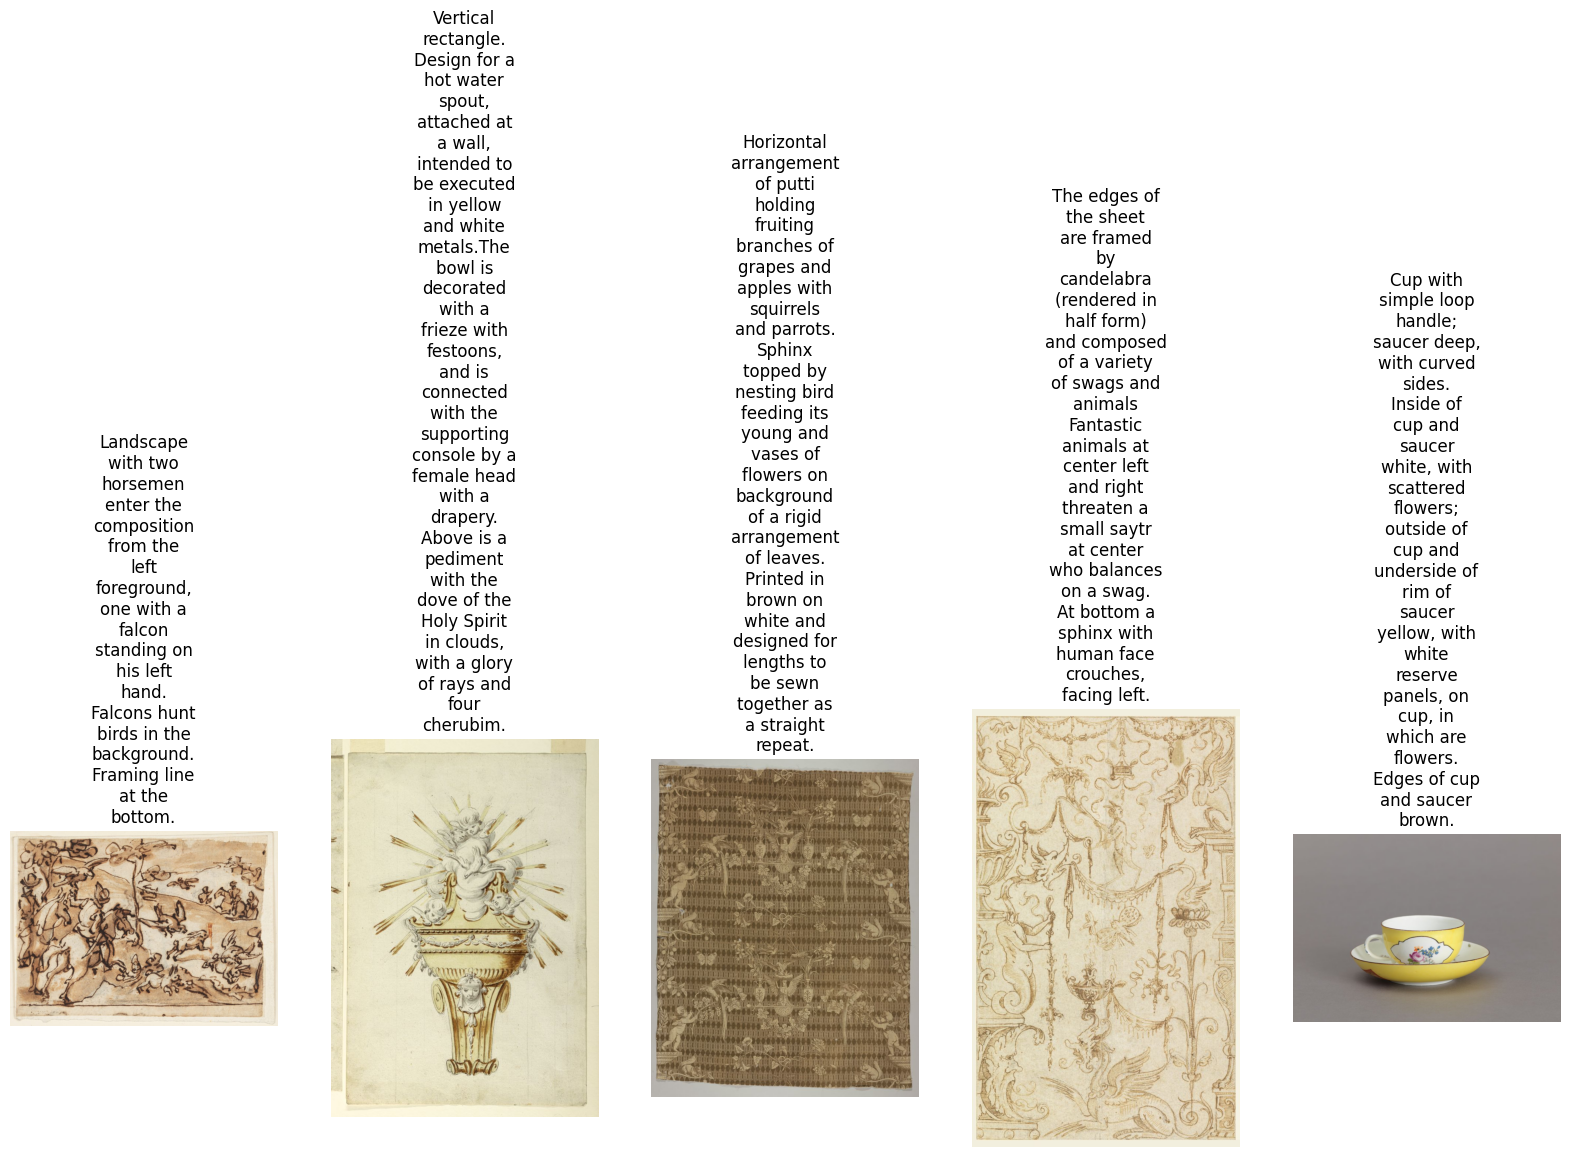

In [10]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(ds_train[i]["image"]) for i in range(5)]
sample_captions = [ds_train[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)


In [11]:
# https://huggingface.co/docs/transformers/tasks/image_captioning
def transforms(example_batch):
    images = [x.convert("RGB").resize((100,100)) for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


ds_train.set_transform(transforms)
ds_test.set_transform(transforms)


## Train

In [12]:
import evaluate
import torch

#rouge = evaluate.load('rouge')
wer = evaluate.load('wer')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    #score = rouge.compute(predictions=decoded_predictions, references=decoded_labels)
    score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"score": score}


In [14]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    # Model saving
    output_dir=f"{model_name}-finetune",
    push_to_hub=False,
    # Hardware support
    #fp16=True,
    use_cpu=True,
    use_ipex=True,
    # Basics
    num_train_epochs=5,
    learning_rate=5e-5,
    label_names=["labels"],
    # Other
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    load_best_model_at_end=True,

)


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    compute_metrics=compute_metrics,
)


In [16]:
import gc

gc.collect()

#torch.cuda.empty_cache()


595

In [17]:
trainer.train()


/home/christian/.local/lib/python3.10/site-packages/intel_extension_for_pytorch/optim/_optimizer_utils.py:385: UserWarning: Does not suport fused step for <class 'torch.optim.adamw.AdamW'>, will use non-fused step
  warnings.warn(


Step,Training Loss,Validation Loss


/home/christian/.local/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/christian/.local/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/christian/.local/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/christian/.local/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/home/christian/.local/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:469: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


: 